IMPORT

In [1]:
import pandas as pd
from zipfile import ZipFile
import urllib.request
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from time import time
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
import scipy.sparse as sp
from scipy.sparse import csr_array
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

TAKE DATASETS AND CREATE DATAFRAMES

In [2]:
zip_url = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"

# Download the ZIP file
zip_file_path, _ = urllib.request.urlretrieve(zip_url, "ml-latest.zip")

# Extract the contents of the ZIP file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Load the required CSV files
ratings = pd.read_csv("https://files.grouplens.org/datasets/rating-disposition-2023/ratings.csv")
movies = pd.read_csv("ml-latest/movies.csv")

# Preprocess data
movies_ids = set(movies['movieId'])
ratings = ratings[ratings['movieId'].isin(movies_ids)]

# Cancel tstamp column
ratings.drop(['tstamp'], axis=1, inplace=True)

# Cancel title column
movies.drop(['title'], axis=1, inplace=True)

print('Ratings Dataframe')
print(ratings)
print('\nMovies Dataframe')
print(movies)

Ratings Dataframe
         userId  movieId  rating
0           206     4803     4.0
1          5073    72731     4.0
2          4739    91653     4.0
3           535     3005     3.0
4           465     4776     3.0
...         ...      ...     ...
3908652    2099    77328     4.5
3908653    2024   148652     3.5
3908654    3751    60684     1.0
3908655      17     2694     3.0
3908656    1684     3948     3.5

[3852425 rows x 3 columns]

Movies Dataframe


<ipython-input-2-29c745c66a6a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop(['tstamp'], axis=1, inplace=True)


,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy


In [3]:
# Create a crosstab
crosstab_result = pd.crosstab(ratings['movieId'], ratings['userId'], values=ratings['rating'], aggfunc='sum')
print("CrossTab: ")
crosstab_result.head()

CrossTab: 


userId,1,2,3,4,5,6,7,8,9,10,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,5.0,3.0,4.0,4.5,NaN,4.0,2.5,...,5.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,3.0,NaN,2.5,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Save all the movie id from the crossTab
movie_ids_list = crosstab_result.index.tolist()
print("Movie Ids: ")
print(movie_ids_list)

Movie Ids: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227,

In [5]:
# Convert the crossTab into a matrix replacing NaN with 0
matrix_array = np.nan_to_num(crosstab_result.to_numpy(), nan=0)
print(matrix_array)

[[4. 3. 4. ... 0. 0. 3.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# Convert the matrix created before into a Sparse Matrix
sparse_matrix = sp.csr_matrix(matrix_array)

Plot of the elbow curve

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


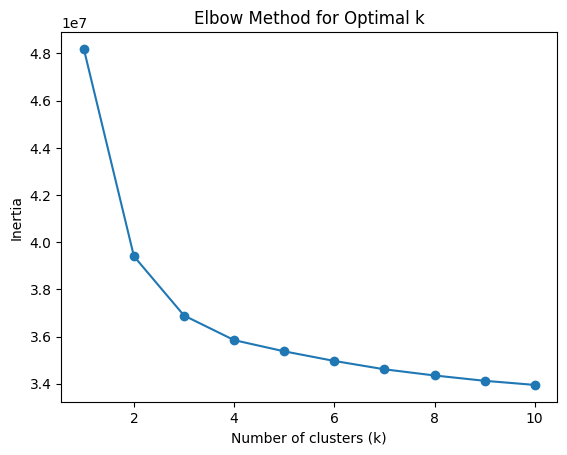

In [7]:
# Find optimal k using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sparse_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
# Clustering with KMeans
optimal_k = 3  # choose based on the elbow method
t0 = time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(sparse_matrix)
print("done in %0.3fs" % (time() - t0))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done in 6.300s


In [20]:
# Chek the dimensions of the arrays
print("Shapes:")
print(len(movie_ids_list))
print(len(cluster_labels))

# Combine the 2 arrays in a matrix
matrix = np.vstack((movie_ids_list, cluster_labels))
print("\nMatrix:")
print(matrix)

# convert the matrix into a dataframe
result_df = pd.DataFrame(matrix.T, columns=['movieId', 'cluster'])
print("\nDataFrame:")
result_df.head()

Shapes:
65107
65107

Matrix:
[[     1      2      3 ... 270588 270590 270592]
 [     1      1      0 ...      0      0      0]]

DataFrame:


,movieId,cluster
0,1,1
1,2,1
2,3,0
3,4,0
4,5,2


WordCloud plot and count of the genres

Final Data Frame:
         userId  movieId  rating  cluster  \
0           206     4803     4.0        0   
1          5073    72731     4.0        2   
2          4739    91653     4.0        2   
3           535     3005     3.0        2   
4           465     4776     3.0        1   
...         ...      ...     ...      ...   
3852420    2099    77328     4.5        0   
3852421    2024   148652     3.5        0   
3852422    3751    60684     1.0        1   
3852423      17     2694     3.0        2   
3852424    1684     3948     3.5        1   

                                            genres  
0                                   Drama|Thriller  
1              Crime|Drama|Fantasy|Horror|Thriller  
2                                     Comedy|Drama  
3                                         Thriller  
4                             Crime|Drama|Thriller  
...                                            ...  
3852420               Crime|Drama|Mystery|Thriller  
3852421          

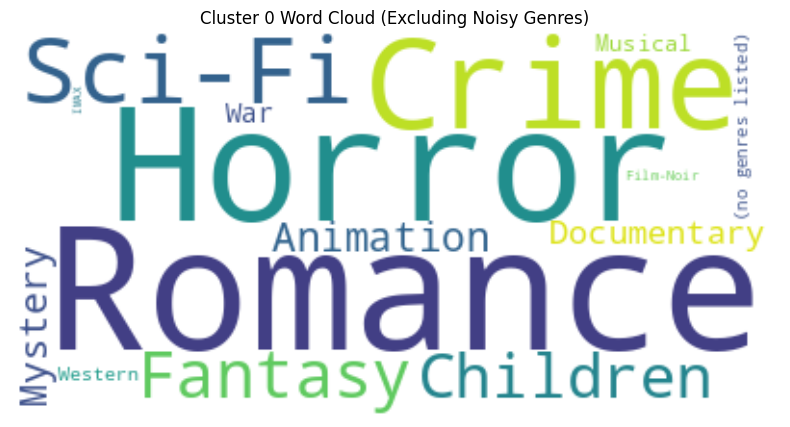



The genres for each cluster: 
{'cluster': 1, 'Drama': 436344, 'Action': 427234, 'Adventure': 370060, 'Thriller': 313756, 'Sci-Fi': 313351, 'Comedy': 265599, 'Crime': 218678, 'Fantasy': 163862, 'IMAX': 138005, 'Mystery': 108770, 'Romance': 108665, 'Animation': 93991, 'Children': 89990, 'War': 61471, 'Horror': 51774, 'Musical': 19937, 'Western': 15164, 'Film-Noir': 9458}


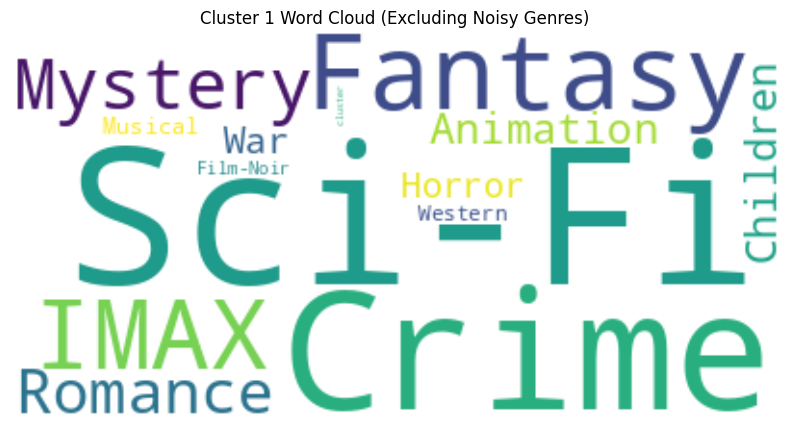



The genres for each cluster: 
{'cluster': 2, 'Drama': 690880, 'Comedy': 558996, 'Action': 486166, 'Thriller': 468095, 'Adventure': 341366, 'Sci-Fi': 272825, 'Romance': 257169, 'Crime': 246374, 'Fantasy': 184010, 'Horror': 149526, 'Mystery': 137151, 'Children': 131148, 'Animation': 124273, 'IMAX': 67506, 'War': 59471, 'Musical': 51408, 'Western': 27114, 'Documentary': 20976, 'Film-Noir': 13871, '(no genres listed)': 6428}


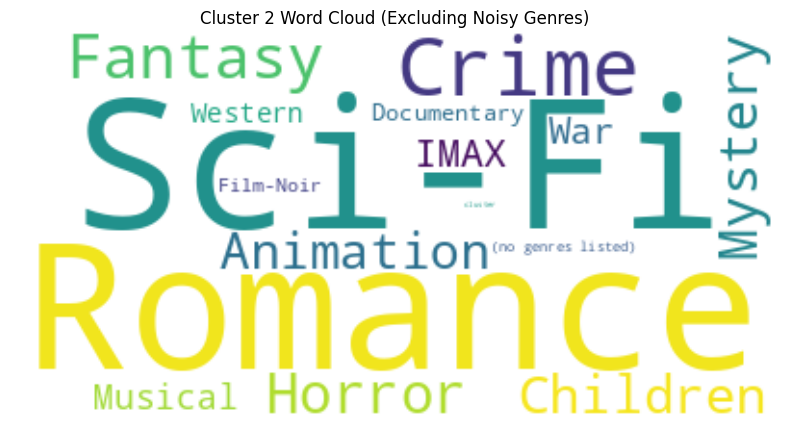

In [21]:
# Combine result_df dataframe with the ratings dataframe
merged_cluster_df = pd.merge(ratings, result_df, on='movieId', how='left')

# Combine movies dataframe with the ratings dataframe
merged_cluster_genres_df = pd.merge(merged_cluster_df, movies, on='movieId', how='left')
print("Final Data Frame:")
print(merged_cluster_genres_df)

# Divide the generes by '|'
merged_cluster_genres_df['genres'] = merged_cluster_genres_df['genres'].str.split('|')

# Explode the 'genres' column
merged_cluster_genres_df = merged_cluster_genres_df.explode('genres')

# Count occurrences by 'cluster' and 'genres'
genre_counts = merged_cluster_genres_df.groupby(['cluster', 'genres']).size().reset_index(name='count')

# Convert the result to a list of dictionaries and sort by 'cluster' and then by genre count
result_list = [
    {'cluster': cluster_id, **{genre: count for genre, count in group.sort_values('count', ascending=False)[['genres', 'count']].values}}
    for cluster_id, group in genre_counts.groupby('cluster')
]

print("Counts of the genres for each cluster: ")


noisy_genres = ["Comedy", "Drama", "Thriller", "Action", "Adventure"]
i=0
for cluster_info in result_list:
    cluster_id = cluster_info['cluster']

    # Exclude noisy genres from the cluster_info
    cluster_info_filtered = {genre: count for genre, count in cluster_info.items() if genre not in noisy_genres}

    # Plot the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white', stopwords=STOPWORDS.union(noisy_genres)).generate_from_frequencies(cluster_info_filtered)
    print("The genres for each cluster: ")
    print(result_list[i])
    i=i+1
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Word Cloud (Excluding Noisy Genres)')
    plt.show()
    print("\n")

Truncated SVD

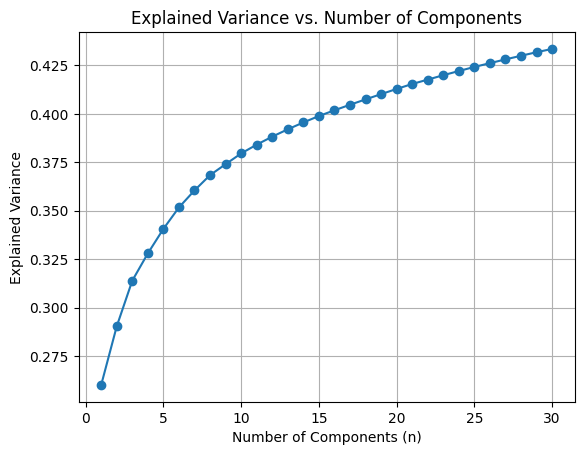

In [14]:
optimal_svd = 30  # e.g. 30, 50, 100
explained_variances = []

for n in range(1, optimal_svd + 1):
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd_result = svd.fit_transform(sparse_matrix)
    explained_variances.append(np.sum(svd.explained_variance_ratio_))

# Plot the explained variance against the number of components
plt.plot(range(1, optimal_svd + 1), explained_variances, marker='o')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components (n)')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

In [11]:
#apply Truncated SVD to the sparse matrix
optimal_svd = 20  # 20,50,100
svd = TruncatedSVD(n_components=optimal_svd, random_state=42)
svd_result = svd.fit_transform(sparse_matrix)

# Print the shapes
print("Original Sparse Matrix Shape:", sparse_matrix.shape)
print("Reduced Dimension Matrix Shape (TruncatedSVD):", svd_result.shape)

Original Sparse Matrix Shape: (65107, 6724)
Reduced Dimension Matrix Shape (TruncatedSVD): (65107, 20)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

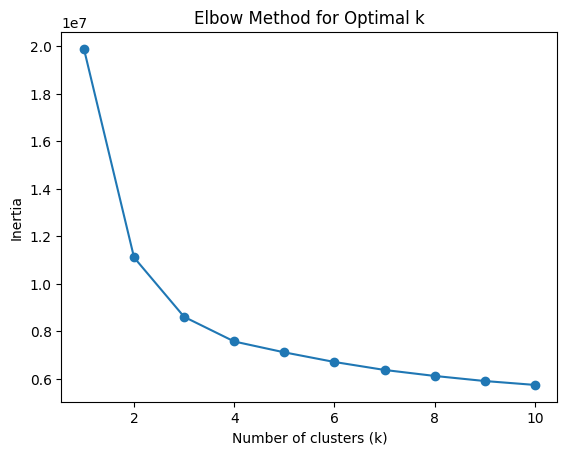

In [12]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(svd_result)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [22]:
optimal_k_svd = 3  # choose based on the elbow method
t0 = time()
kmeans = KMeans(n_clusters=optimal_k_svd, random_state=42)
cluster_labels_svd = kmeans.fit_predict(svd_result)
print("done in %0.3fs" % (time() - t0))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done in 1.971s


In [23]:
# chek the dimensions of the arrays
print("Shapes:")
print(len(movie_ids_list))
print(len(cluster_labels_svd))

# combine the 2 arrays in a matrx
matrix_svd = np.vstack((movie_ids_list, cluster_labels_svd))
print("\nMatrix:")
print(matrix_svd)

# Convert matrix to a dataframe
result_df_svd = pd.DataFrame(matrix_svd.T, columns=['movieId', 'cluster'])
print("\nDataFrame:")
print(result_df_svd)

Shapes:
65107
65107

Matrix:
[[     1      2      3 ... 270588 270590 270592]
 [     1      1      0 ...      0      0      0]]

DataFrame:
       movieId  cluster
0            1        1
1            2        1
2            3        0
3            4        0
4            5        2
...        ...      ...
65102   270580        0
65103   270582        0
65104   270588        0
65105   270590        0
65106   270592        0

[65107 rows x 2 columns]


Final Data Frame:
         userId  movieId  rating  cluster  \
0           206     4803     4.0        0   
1          5073    72731     4.0        2   
2          4739    91653     4.0        2   
3           535     3005     3.0        2   
4           465     4776     3.0        1   
...         ...      ...     ...      ...   
3852420    2099    77328     4.5        0   
3852421    2024   148652     3.5        0   
3852422    3751    60684     1.0        1   
3852423      17     2694     3.0        2   
3852424    1684     3948     3.5        1   

                                            genres  
0                                   Drama|Thriller  
1              Crime|Drama|Fantasy|Horror|Thriller  
2                                     Comedy|Drama  
3                                         Thriller  
4                             Crime|Drama|Thriller  
...                                            ...  
3852420               Crime|Drama|Mystery|Thriller  
3852421          

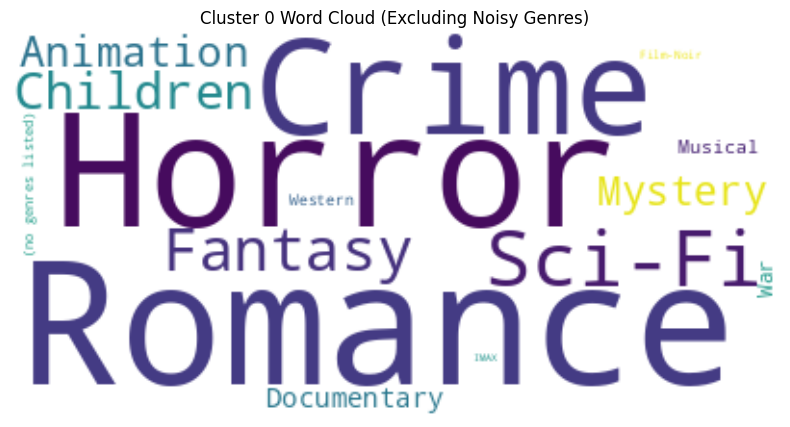




 Genres for each cluster: 
{'cluster': 1, 'Drama': 436344, 'Action': 427234, 'Adventure': 370060, 'Thriller': 313756, 'Sci-Fi': 313351, 'Comedy': 265599, 'Crime': 218678, 'Fantasy': 163862, 'IMAX': 138005, 'Mystery': 108770, 'Romance': 108665, 'Animation': 93991, 'Children': 89990, 'War': 61471, 'Horror': 51774, 'Musical': 19937, 'Western': 15164, 'Film-Noir': 9458}


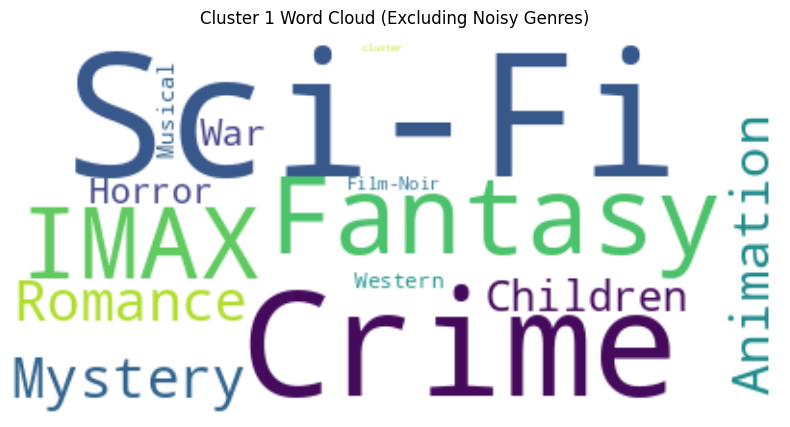




 Genres for each cluster: 
{'cluster': 2, 'Drama': 691727, 'Comedy': 558583, 'Action': 486525, 'Thriller': 468173, 'Adventure': 341730, 'Sci-Fi': 272825, 'Romance': 257169, 'Crime': 246447, 'Fantasy': 184420, 'Horror': 149526, 'Mystery': 137151, 'Children': 131558, 'Animation': 124683, 'IMAX': 67916, 'War': 59471, 'Musical': 51408, 'Western': 27114, 'Documentary': 20377, 'Film-Noir': 13871, '(no genres listed)': 6428}


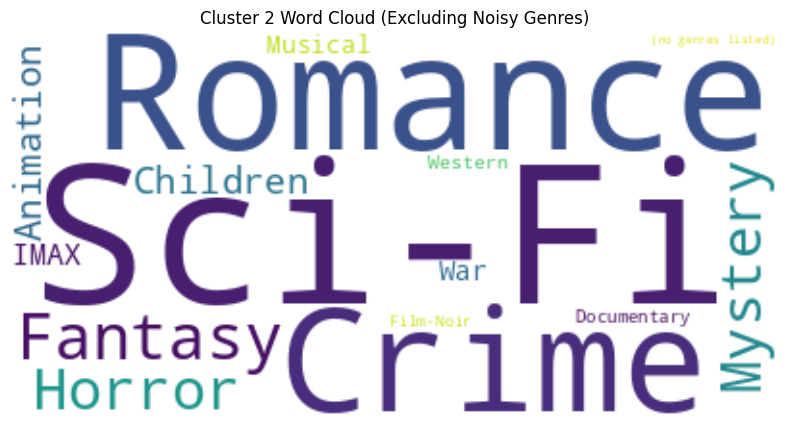

In [24]:
# Combine result_df_svd dataframe with the ratings dataframe
merged_cluster_df_svd = pd.merge(ratings, result_df_svd, on='movieId', how='left')

# Combine movies dataframe with the ratings dataframe
merged_cluster_genres_df_svd = pd.merge(merged_cluster_df_svd, movies, on='movieId', how='left')
print("Final Data Frame:")
print(merged_cluster_genres_df_svd)

merged_cluster_genres_df_svd['genres'] = merged_cluster_genres_df_svd['genres'].str.split('|')

# Explode the 'genres' column
merged_cluster_genres_df_svd = merged_cluster_genres_df_svd.explode('genres')

# Count occurrences by 'cluster' and 'genres'
genre_counts_svd = merged_cluster_genres_df_svd.groupby(['cluster', 'genres']).size().reset_index(name='count')

# Convert the result to a list of dictionaries and sort by 'cluster' and then by genre count
result_list_svd = [
    {'cluster': cluster_id, **{genre: count for genre, count in group.sort_values('count', ascending=False)[['genres', 'count']].values}}
    for cluster_id, group in genre_counts_svd.groupby('cluster')
]


noisy_genres = ["Comedy", "Drama", "Thriller", "Action", "Adventure"]
i=0
for cluster_info in result_list_svd:
    cluster_id = cluster_info['cluster']

    # Exclude noisy genres from the cluster_info
    cluster_info_filtered = {genre: count for genre, count in cluster_info.items() if genre not in noisy_genres}

    # Plot the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white', stopwords=STOPWORDS.union(noisy_genres)).generate_from_frequencies(cluster_info_filtered)
    print("\n Genres for each cluster: ")
    print(result_list_svd[i])
    i=i+1
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Word Cloud (Excluding Noisy Genres)')
    plt.show()
    print("\n")